# Load Dataset from Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [2]:
import re
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

In [3]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

In [4]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Pepaya: 
 	168 train images, 47 validation images, and 25 test images,  total 240 images

Jambu Biji: 
 	154 train images, 44 validation images, and 23 test images,  total 221 images

Mint: 
 	302 train images, 85 validation images, and 45 test images,  total 432 images

Kelor: 
 	153 train images, 43 validation images, and 23 test images,  total 219 images

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Bayam Hijau: 
 	206 train images, 58 validation images, and 31 test images,  total 295 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images

Basil: 
 	103 train images, 29 validation images, and 16 test images,  total 148 images



In [5]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def train_val_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                rotation_range = 25,
                                zoom_range = [0.5, 1.1],
                                width_shift_range=0.15, 
                                shear_range= 0.15,
                                height_shift_range=0.15,
                                preprocessing_function=preprocess_input,
                                horizontal_flip=True,
                                vertical_flip= True,
                                fill_mode='nearest',)
  
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32, 
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  
    validation_datagen = ImageDataGenerator(rescale = 1/255,
                                            preprocessing_function=preprocess_input)
  
    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    ### END CODE HERE
    test_datagen = ImageDataGenerator(rescale= 1./255.)
  
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generator(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator
  

  def build_model(self, compile_config):
    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    # self.base_model.trainable = self.trainable
    flatten_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(512, activation='relu')
    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    self.model = tf.keras.models.Sequential([
                                             self.base_model,
                                             flatten_layer,
                                             dense_layer_1,
                                             prediction_layer])

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
  
    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()
    
    plt.show()

  def evaluate_model(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')
  
    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')
  
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
  
  def find_best_model(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight
    
    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_model(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.model.load_weights(self.best_weight)
    self.evaluate_model()
  
  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)
  
  def load_best_model(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 12,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": 'adam',
    "metrics": ["acc"],
}
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=config['input_shape'])
vgg16.trainable = False
vgg16_model = Model(model=vgg16, config=config)
vgg16_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg16_preprocess_input)
vgg16_model.build_model(compile_config)

Found 1876 images belonging to 12 classes.
Found 521 images belonging to 12 classes.
Found 275 images belonging to 12 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dense_7 (Dense)             (None, 12)                6156      
                                                                 
Total params: 27,566,412
Trainable params: 12,851,724
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg16_model.train(model_name='vgg16')

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 2.6208 - acc: 0.4893 
Epoch 1: val_acc improved from -inf to 0.73129, saving model to vgg16-saved-model-01-acc-0.73.hdf5
59/59 [==============================] - 959s 16s/step - loss: 2.6208 - acc: 0.4893 - val_loss: 0.8684 - val_acc: 0.7313
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 0.8304 - acc: 0.7308
Epoch 2: val_acc improved from 0.73129 to 0.77351, saving model to vgg16-saved-model-02-acc-0.77.hdf5
59/59 [==============================] - 225s 4s/step - loss: 0.8304 - acc: 0.7308 - val_loss: 0.6914 - val_acc: 0.7735
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 0.7118 - acc: 0.7676
Epoch 3: val_acc improved from 0.77351 to 0.80806, saving model to vgg16-saved-model-03-acc-0.81.hdf5
59/59 [==============================] - 224s 4s/step - loss: 0.7118 - acc: 0.7676 - val_loss: 0.6167 - val_acc: 0.8081
Epoch 4/20
59/59 [==============================] - ETA: 0s - loss: 

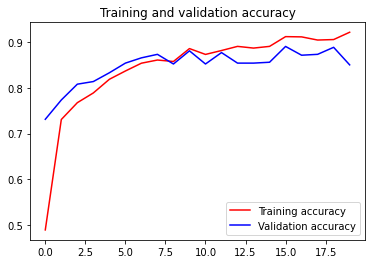

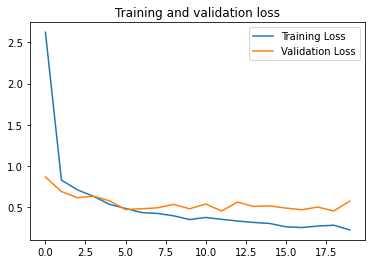

In [ ]:
vgg16_model.plot_history()

1/9 [==>...........................] - ETA: 38s - loss: 0.0983 - acc: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 97s 12s/step - loss: 0.7911 - acc: 0.8291
Loss of the model is -  0.7911089062690735
Accuracy of the model is -  82.90908932685852 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.64      0.97      0.77        29
  Jambu Biji       0.70      0.80      0.74        20
 Jeruk Purut       0.75      0.23      0.35        13
       Kelor       0.61      0.91      0.73        22
      Kersen       0.92      0.85      0.88        13
       Lemon       1.00      0.78      0.88        23
    Lengkuas       1.00      0.40      0.57        10
      Mangga       1.00      0.98      0.99        45
        Mint       0.88      0.80      0.84        45
      Nangka       0.87      0.87      0.87        15
      Pepaya       0.90      0.79      0.84        24

    accuracy                           0.83       275
   macro avg       0.85      0.78      0.79       275
weighted avg    

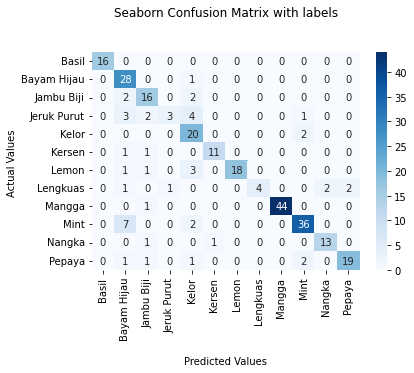

In [ ]:
vgg16_model.evaluate_model()

In [ ]:
vgg16_model.model_name = 'vgg16'
vgg16_model.find_best_model('.')

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 29s 3s/step - loss: 0.6255 - acc: 0.8364
Loss of the model is -  0.6255186200141907
Accuracy of the model is -  83.63636136054993 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.68      0.97      0.80        29
  Jambu Biji       0.79      0.75      0.77        20
 Jeruk Purut       0.67      0.46      0.55        13
       Kelor       0.76      0.73      0.74        22
      Kersen       0.91      0.77      0.83        13
       Lemon       1.00      0.65      0.79        23
    Lengkuas       1.00      0.50      0.67        10
      Mangga       1.00      0.98      0.99        45
        Mint       0.82      0.93      0.87        45
      Nangka       0.67      0.80      0.73        15
      Pepaya       0.84      0.88      0.86        24

    accuracy                           0.84       275
   macro avg       0.85      0.78      0.80       275
weighted avg     

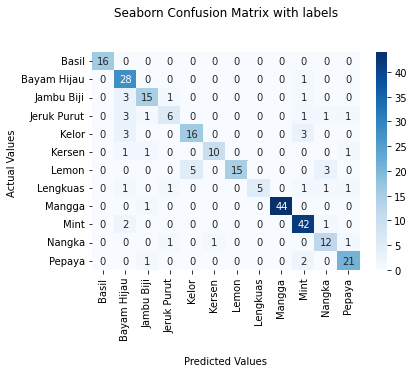

In [ ]:
vgg16_model.evaluate_best_model()

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.001),
    "metrics": ["accuracy"],
}

inceptionv3  = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'], classes=config['classes'])
inceptionv3.trainable=False
# for layer in inceptionv3.layers[:249]:
#    layer.trainable = False
# for layer in inceptionv3.layers[249:]:
#    layer.trainable = True

iv3_model = Model(model=inceptionv3, config=config)
iv3_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)
iv3_model.build_model(compile_config)

87924736/87910968 [==============================] - 0s 0us/step
Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 48,021,800
Trainable params: 26,219,016
Non-trainable params: 21,802,784
____________________________________________

In [9]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
iv3_model.train('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 3.7892 - acc: 0.3531 
Epoch 1: val_acc improved from -inf to 0.45667, saving model to inceptionv3-saved-model-01-acc-0.46.hdf5
48/48 [==============================] - 865s 18s/step - loss: 3.7892 - acc: 0.3531 - val_loss: 2.2845 - val_acc: 0.4567 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.6114 - acc: 0.4625
Epoch 2: val_acc improved from 0.45667 to 0.54801, saving model to inceptionv3-saved-model-02-acc-0.55.hdf5
48/48 [==============================] - 212s 4s/step - loss: 1.6114 - acc: 0.4625 - val_loss: 1.4191 - val_acc: 0.5480 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.2994 - acc: 0.5231
Epoch 3: val_acc did not improve from 0.54801
48/48 [==============================] - 211s 4s/step - loss: 1.2994 - acc: 0.5231 - val_loss: 1.5051 - val_acc: 0.5152 - lr: 0.0010
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 1.199

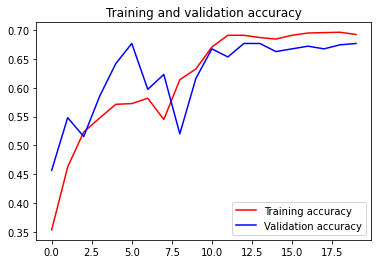

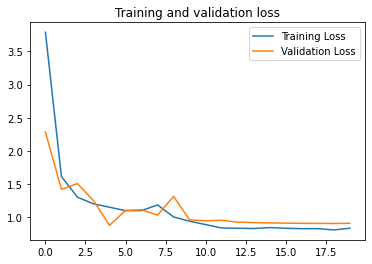

In [11]:
iv3_model.plot_history()

1/7 [===>..........................] - ETA: 28s - loss: 45.7475 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 84s 13s/step - loss: 41.1747 - acc: 0.1295
Loss of the model is -  41.17474365234375
Accuracy of the model is -  12.94642835855484 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.20      0.32      0.25        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.12      0.92      0.21        24

    accuracy                           0.13       224
   macro avg       0.04      0.15      0.06       224
weighted avg       0.03      0.13      0.05       224

Confusion Matrix


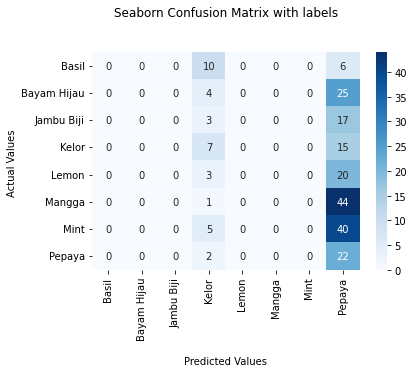

In [12]:
iv3_model.evaluate_model()

./inceptionv3-saved-model-06-acc-0.68.hdf5
1/7 [===>..........................] - ETA: 28s - loss: 47.5594 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 23s 3s/step - loss: 39.5158 - acc: 0.1205
Loss of the model is -  39.515769958496094
Accuracy of the model is -  12.05357164144516 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.13      0.59      0.21        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.11      0.58      0.19        24

    accuracy                           0.12       224
   macro avg       0.03      0.15      0.05       224
weighted avg       0.02      0.12      0.04       224

Confusion Matrix


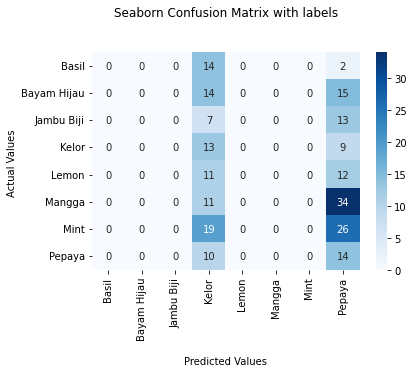

In [13]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_model('.')
iv3_model.evaluate_best_model()

In [14]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
iv3_model.save_best_model(target_dir=target_dir)

Copy ./inceptionv3-saved-model-06-acc-0.68.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 12,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": 'adam',
    "metrics": ["accuracy"],
}
resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=config['input_shape'], classes=config['classes'])
resnet50.trainable = False
resnet50_model = Model(model=resnet50, config=config)
resnet50_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=resnet50_preprocess_input)
resnet50_model.build_model(compile_config)

Found 1876 images belonging to 12 classes.
Found 521 images belonging to 12 classes.
Found 275 images belonging to 12 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dense_5 (Dense)             (None, 12)                6156      
                                                                 
Total params: 74,974,604
Trainable params: 51,386,892
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
resnet50_model.train('resnet50', reduce_lr_config=reduce_lr_config)

Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 7.9133 - acc: 0.2031
Epoch 1: val_acc improved from -inf to 0.17850, saving model to resnet50-saved-model-01-acc-0.18.hdf5
59/59 [==============================] - 235s 4s/step - loss: 7.9133 - acc: 0.2031 - val_loss: 2.9746 - val_acc: 0.1785 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 2.4663 - acc: 0.3017
Epoch 2: val_acc improved from 0.17850 to 0.31478, saving model to resnet50-saved-model-02-acc-0.31.hdf5
59/59 [==============================] - 227s 4s/step - loss: 2.4663 - acc: 0.3017 - val_loss: 3.1347 - val_acc: 0.3148 - lr: 0.0010
Epoch 3/20
59/59 [==============================] - ETA: 0s - loss: 2.4426 - acc: 0.3273
Epoch 3: val_acc did not improve from 0.31478
59/59 [==============================] - 222s 4s/step - loss: 2.4426 - acc: 0.3273 - val_loss: 2.4310 - val_acc: 0.2572 - lr: 0.0010
Epoch 4/20
59/59 [==============================] - ETA: 0s - loss: 2.3713 - acc:

./resnet50-saved-model-18-acc-0.48.hdf5
1/9 [==>...........................] - ETA: 37s - loss: 1.7265 - acc: 0.2500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 102s 12s/step - loss: 1.4562 - acc: 0.4764
Loss of the model is -  1.4562342166900635
Accuracy of the model is -  47.63636291027069 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.34      0.41      0.38        29
  Jambu Biji       0.86      0.30      0.44        20
 Jeruk Purut       0.00      0.00      0.00        13
       Kelor       0.34      0.68      0.45        22
      Kersen       1.00      0.23      0.38        13
       Lemon       0.50      0.17      0.26        23
    Lengkuas       0.60      0.30      0.40        10
      Mangga       0.58      1.00      0.74        45
        Mint       0.53      0.42      0.47        45
      Nangka       0.62      0.53      0.57        15
      Pepaya       0.35      0.67      0.46        24

    accuracy                           0.48       275
   macro avg       0.48      0.39      0.38       275
weighted avg       0.48      0.48      0.43       275

Confusion Matrix


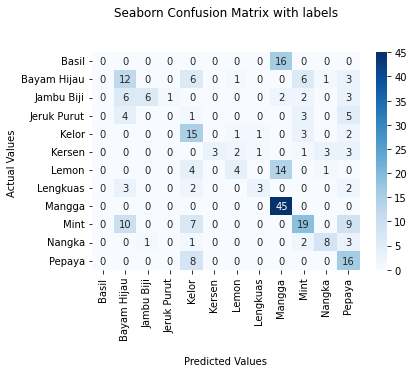

In [ ]:
resnet50_model.model_name = 'resnet50'
resnet50_model.find_best_model('.')
resnet50_model.evaluate_best_model()

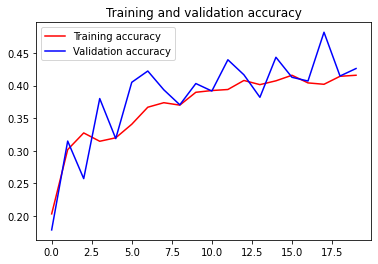

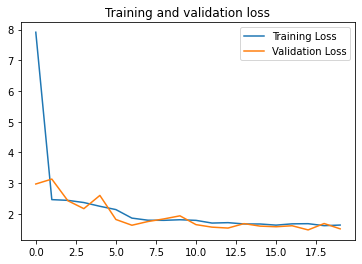

In [ ]:
resnet50_model.plot_history()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
resnet50_model.save_best_model(target_dir=target_dir)

Copy ./resnet50-saved-model-18-acc-0.48.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


In [15]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.001),
    "metrics": ["accuracy"],
}
vgg19 = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=config['input_shape'],
        pooling='avg',
        classes=config['classes'],
        classifier_activation='softmax',
)

vgg19.trainable = False
vgg19_model = Model(model=vgg19, config=config)
vgg19_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg19_preprocess_input)
vgg19_model.build_model(compile_config)

80150528/80134624 [==============================] - 0s 0us/step
Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 20,291,144
Trainable params: 266,760
Non-trainable params: 20,024,384
_____________________________________________

In [16]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
vgg19_model.train('vgg19', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.5555 - acc: 0.4381
Epoch 1: val_acc improved from -inf to 0.62295, saving model to vgg19-saved-model-01-acc-0.62.hdf5
48/48 [==============================] - 219s 5s/step - loss: 1.5555 - acc: 0.4381 - val_loss: 1.1148 - val_acc: 0.6230 - lr: 0.0010
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.9716 - acc: 0.6660
Epoch 2: val_acc improved from 0.62295 to 0.76581, saving model to vgg19-saved-model-02-acc-0.77.hdf5
48/48 [==============================] - 211s 4s/step - loss: 0.9716 - acc: 0.6660 - val_loss: 0.7798 - val_acc: 0.7658 - lr: 0.0010
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.8020 - acc: 0.7312
Epoch 3: val_acc improved from 0.76581 to 0.76815, saving model to vgg19-saved-model-03-acc-0.77.hdf5
48/48 [==============================] - 210s 4s/step - loss: 0.8020 - acc: 0.7312 - val_loss: 0.6987 - val_acc: 0.7681 - lr: 0.0010
Epoch 4/20
48/48 [=============

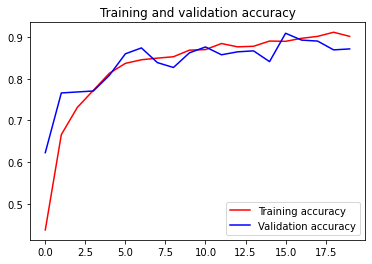

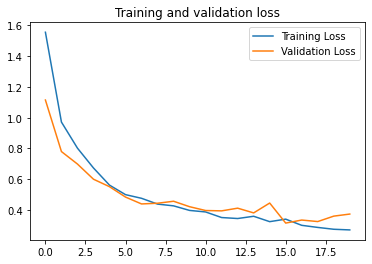

In [17]:
vgg19_model.plot_history()

./vgg19-saved-model-16-acc-0.91.hdf5
1/7 [===>..........................] - ETA: 28s - loss: 0.1640 - acc: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 22s 3s/step - loss: 0.3951 - acc: 0.8705
Loss of the model is -  0.39510536193847656
Accuracy of the model is -  87.05357313156128 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.86      0.86      0.86        29
  Jambu Biji       0.83      0.95      0.88        20
       Kelor       0.65      0.91      0.75        22
       Lemon       0.89      0.70      0.78        23
      Mangga       0.98      0.96      0.97        45
        Mint       0.92      0.78      0.84        45
      Pepaya       0.84      0.88      0.86        24

    accuracy                           0.87       224
   macro avg       0.87      0.88      0.87       224
weighted avg       0.88      0.87      0.87       224

Confusion Matrix


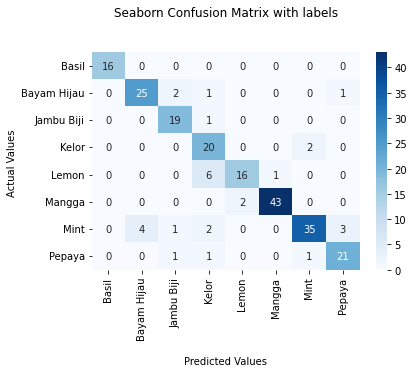

In [18]:
vgg19_model.model_name = 'vgg19'
vgg19_model.find_best_model('.')
vgg19_model.evaluate_best_model()

In [19]:

target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
vgg19_model.save_best_model(target_dir=target_dir)

Copy ./vgg19-saved-model-16-acc-0.91.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


In [20]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [21]:
!wget https://media.discordapp.net/attachments/971451202267119678/977480585750667294/IMG20220521145825.jpg -O daun8.jpg

--2022-05-29 12:36:31--  https://media.discordapp.net/attachments/971451202267119678/977480585750667294/IMG20220521145825.jpg
Resolving media.discordapp.net (media.discordapp.net)... 162.159.128.232, 162.159.129.232, 162.159.130.232, ...
Connecting to media.discordapp.net (media.discordapp.net)|162.159.128.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2433187 (2.3M) [image/jpeg]
Saving to: ‘daun8.jpg’

daun8.jpg           100%[===================>]   2.32M  --.-KB/s    in 0.03s   

2022-05-29 12:36:31 (79.8 MB/s) - ‘daun8.jpg’ saved [2433187/2433187]



In [ ]:
model = vgg19_model.model
label_map = (train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='daun8.jpg'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

In [ ]:
train_generator.class_indices

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img =  cv2.imread('/istockphoto-584504750-1024x1024.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color 
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= mask)

cv2_imshow(img)
cv2_imshow(res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
train_generator.class_indices

{'Bayam Hijau': 0,
 'Jahe': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mint': 8,
 'Nangka': 9,
 'Pepaya': 10}